In [1]:
import numpy as np
import pandas as pd

import conv_model as conv
import batch_hist as hist
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate
from scipy.ndimage import shift

In [2]:
#### User input ####

## path of the train and test data
train_data = "../data/digit-recognizer/train.csv"
test_data = "../data/digit-recognizer/test.csv"

In [3]:
## read data into Dataframe
df_train = pd.read_csv(train_data)
df_train.info()

df_test = pd.read_csv(test_data)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [4]:
## function to create input images
def create_input_images(df, start = 1):
    im_arr = []
    for row in range(0, len(df.index)):
        ## get the image values
        im_flat = np.array(df.iloc[row, start:])
        
        ## create the image frame
        image = np.reshape(im_flat, (28, 28, 1))
        
        ## Store the normalized version of the image
        im_arr.append(image/255.)

    return np.array(im_arr, dtype = np.float32)

## add a rotation to the dataset
def augment_images(ims, labels, num_rot = 3, num_sm = 2):
    ## initiate a random number generator
    rng = np.random.default_rng(666)
    
    ## create a storage array + classification
    stor_arr, tags = [], []
    
    ## loop over the images
    for i, img in enumerate(ims):
        stor_arr.append(img)
        tags.append(Y[i])
        
        ## get the rotation angles and perform the rotations
        angles = rng.normal(loc = 0., scale = 15., size = num_rot)
        for a in angles:
            rot_im = rotate(img, angle = a, reshape = False)
            rot_im[rot_im < 0.] = 0.
            rot_im[rot_im > 1.] = 1.
            stor_arr.append(rot_im)
            tags.append(Y[i])
            
        ## perform the smoothing and rotation
        angles = rng.normal(loc = 0., scale = 15., size = num_sm)
        sm_vals = rng.normal(loc = 1., scale = 0.08, size = num_sm)
        for a, sm in zip(angles, sm_vals):
            rot_im = rotate(img, angle = a, reshape = False)
            rot_im[rot_im < 0.] = 0.
            rot_im[rot_im > 1.] = 1.
            sm_im = gaussian_filter(rot_im, sigma = (sm, sm, 1.))
            stor_arr.append(sm_im)
            tags.append(Y[i])
    
    return np.array(stor_arr), np.array(tags)
    

In [5]:
## create the arrays of input images
im_arr = create_input_images(df_train)
im_arr_test = create_input_images(df_test, start = 0)

## create training input labels
Y = df_train["label"].to_numpy()
print(Y.shape)

## Augment the training dataset
im_arr, Y = augment_images(im_arr, Y, num_rot = 3, num_sm = 3)
print(im_arr.shape)
print(Y.shape)

## perform one_hot encoding
Y_oh = tf.one_hot(Y, 10)
im_arr.shape

(42000,)
(294000, 28, 28, 1)
(294000,)


(294000, 28, 28, 1)

In [6]:
from tensorflow.keras.losses import CategoricalCrossentropy

#### User input ####
learn_rate = 2.0e-3
epochs = 3
batch_size = 64
num_batches = int(im_arr.shape[0]/batch_size)

In [7]:
## create the model: simple convolutional layers
#model1 = conv.ConvModel(conv_layer = 'Conv2D', drop_rate = 0.25, kernel_size = (3, 3), filters = [48, 32])

## create the model: residual model layers
model1 = conv.ResModel(drop_rate = 0.25, kernel_size = (3, 3), filters = [24, 48])

## create the model: large residual model with 2 x 6 layers
#model1 = conv.ResModelLarge(drop_rate = 0.25, kernel_size = (3, 3))

##instantiate the batch callbacks
batch_history = hist.BatchHistory()

In [8]:
## initialize the adam optimizer with polynomial decay
#poly_decay_rate = tf.keras.optimizers.schedules.PolynomialDecay(learn_rate, epochs) ## with polynomial decay
#Adam_opt = tf.keras.optimizers.Adam(learning_rate = poly_decay_rate) 

Adam_opt = tf.keras.optimizers.Adam(learning_rate = learn_rate) ## without polynomial decay

## compile the model
model1.compile(optimizer = Adam_opt, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

In [9]:
## fit the model (currently just testing the design, no final run yet)
model1.fit(im_arr, Y_oh, batch_size = batch_size, shuffle = True, epochs = epochs, callbacks = [batch_history])

Epoch 1/3
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 179s 39ms/step - accuracy: 0.9575 - loss: 0.1386
Epoch 2/3
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 178s 39ms/step - accuracy: 0.9918 - loss: 0.0261
Epoch 3/3
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 180s 39ms/step - accuracy: 0.9945 - loss: 0.0173


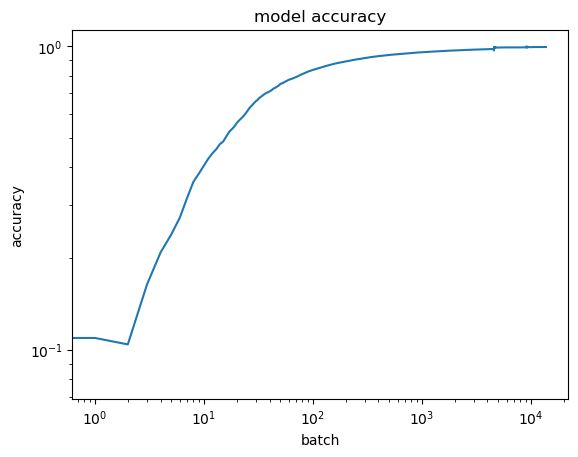

In [10]:
## plot the accuracy evolution during training
import matplotlib.pyplot as plt
plt.plot(batch_history.accuracies)
plt.title('model accuracy')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('accuracy')
plt.xlabel('batch')

plt.show()

In [11]:
## print the model summary
#model1.summary()

In [12]:
## predict for the test data
preds = model1.predict(im_arr_test)

875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


In [13]:
## add test predictions to the test dataframe
#print(preds.shape)
#print(len(np.argmax(preds, axis = 1)))
#print(len(np.arange(1, len(df_test.index)+1)))
#print(df_test.columns)

df_test["Label"] = np.argmax(preds, axis = 1)
df_test["ImageId"] = np.arange(1, len(df_test.index)+1)

In [14]:
## path of the test predictions
#test_pred_path = "../data/digit-recognizer/test_preds14.csv"

## write results to csv file
#to_write = ["ImageId", "Label"]
#df_test.to_csv(test_pred_path, columns = to_write, index = False)

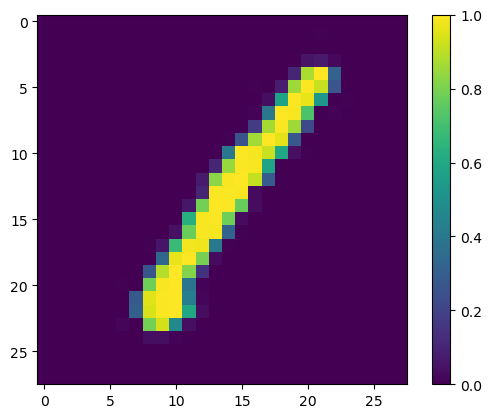

In [15]:
## plot an image
plt.imshow(im_arr[1])
plt.colorbar()

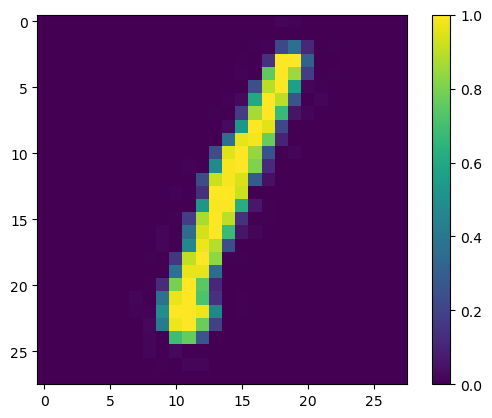

In [16]:
## check rotated image
rot_im = rotate(im_arr[1], angle = 12., reshape = False)
rot_im[rot_im < 0.] = 0.
rot_im[rot_im > 1.] = 1.
plt.imshow(rot_im)
plt.colorbar()

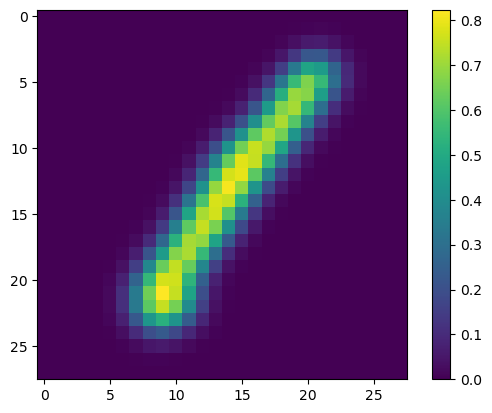

In [17]:
filt_im = gaussian_filter(im_arr[1], sigma = (1.1, 1.1, 1.))
plt.imshow(filt_im)
plt.colorbar()